In [70]:
#Train a neural network to predict nightly price (regression)
#Train a neural network to predict booking status (classification)
# Log training curves to TensorBoard

In [88]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, accuracy_score

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC


In [72]:
REGIONS = [
    ("austin", "tx/austin"),
    ("chicago", "il/chicago"),
    ("santacruz", "ca/santa-cruz-county"),
    ("washingtondc", "dc/washington-dc")
]
SNAPSHOT_DATES = ["2025-03-06", "2024-12-14", "2025-03-11", "2024-12-18", "2025-03-28", "2024-12-31", "2025-03-13"]

BASE_URL = "https://data.insideairbnb.com/united-states"

def get_csv_urls(region_path, date_str):
    path = f"{BASE_URL}/{region_path}/{date_str}/data"
    return {
        "listings": f"{path}/listings.csv.gz",
        "calendar": f"{path}/calendar.csv.gz"
    }

raw_listings = {}
raw_calendar = {}

for city_id, region_path in REGIONS:
    for snapshot in SNAPSHOT_DATES:
        urls = get_csv_urls(region_path, snapshot)
        key = f"{city_id}_{snapshot}"

        try:
            print(f"\nFetching Data: {key} Path: {region_path}")

            listings = pd.read_csv(urls["listings"], compression="gzip")
            calendar = pd.read_csv(urls["calendar"], compression="gzip", low_memory=False)

            print(" listings shape:", listings.shape)
            print(" calendar shape:", calendar.shape)

            raw_listings[key] = listings
            raw_calendar[key] = calendar

        except Exception:
            continue


Fetching Data: austin_2025-03-06 Path: tx/austin
 listings shape: (15431, 79)
 calendar shape: (5635043, 7)

Fetching Data: austin_2024-12-14 Path: tx/austin
 listings shape: (15500, 75)
 calendar shape: (5654056, 7)

Fetching Data: austin_2025-03-11 Path: tx/austin

Fetching Data: austin_2024-12-18 Path: tx/austin

Fetching Data: austin_2025-03-28 Path: tx/austin

Fetching Data: austin_2024-12-31 Path: tx/austin

Fetching Data: austin_2025-03-13 Path: tx/austin

Fetching Data: chicago_2025-03-06 Path: il/chicago

Fetching Data: chicago_2024-12-14 Path: il/chicago

Fetching Data: chicago_2025-03-11 Path: il/chicago
 listings shape: (8748, 79)
 calendar shape: (3187677, 7)

Fetching Data: chicago_2024-12-18 Path: il/chicago
 listings shape: (8691, 75)
 calendar shape: (3169332, 7)

Fetching Data: chicago_2025-03-28 Path: il/chicago

Fetching Data: chicago_2024-12-31 Path: il/chicago

Fetching Data: chicago_2025-03-13 Path: il/chicago

Fetching Data: santacruz_2025-03-06 Path: ca/santa-

In [73]:
def build_panel_simple(listings_df, calendar_df):
    cal = calendar_df.copy()
    lst = listings_df.copy()
    price_cols = [c for c in ["adjusted_price", "price", "base_price"] if c in cal.columns]
    if not price_cols:
        raise KeyError("No price column found in calendar data.")

    price_col = cal[price_cols].notna().sum().idxmax()
    print(" using price column:", price_col)
    keep = ["listing_id", "date", "available", price_col]
    keep = [c for c in keep if c in cal.columns]
    cal = cal[keep].rename(columns={price_col: "raw_price"})
    df = cal.merge(lst, left_on="listing_id", right_on="id", how="inner")

    df["price_numeric"] = (
        df["raw_price"]
        .astype(str)
        .str.replace(r"[^0-9.]", "", regex=True)
        .replace("", np.nan)
        .astype(float)
    )
    df["is_booked"] = (df["available"] == "f").astype(float)
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["month"] = df["date"].dt.month
    df["day_of_week"] = df["date"].dt.dayofweek
    df["week_of_year"] = df["date"].dt.isocalendar().week.astype(int)
    df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)
    df["day_of_year"] = df["date"].dt.dayofyear

    print(" missing price rows:", df["price_numeric"].isna().sum())

    return df


In [74]:
cal = raw_calendar["austin_2025-03-06"]
print(cal.columns.tolist())
for c in ["price", "adjusted_price", "base_price"]:
    if c in cal.columns:
        print(
            c,
            "non-null:", cal[c].notna().sum(),
            "sample:", cal[c].dropna().head(3).tolist()
        )

['listing_id', 'date', 'available', 'price', 'adjusted_price', 'minimum_nights', 'maximum_nights']
price non-null: 5635043 sample: ['$95.00', '$95.00', '$95.00']
adjusted_price non-null: 5119 sample: ['$2,500.00', '$2,500.00', '$2,900.00']


In [75]:
panel_data = {}
for key in raw_listings.keys():
    print(f"\nBuilding panel for {key}")
    df_panel = build_panel_simple(
        raw_listings[key],
        raw_calendar[key]
    )
    print(" panel shape:", df_panel.shape)
    display(df_panel.head(2))
    panel_data[key] = df_panel.sample(100_000, random_state=42)


Building panel for austin_2025-03-06
 using price column: price
 missing price rows: 0
 panel shape: (5635043, 90)


,listing_id,date,available,raw_price,id,listing_url,scrape_id,last_scraped,source,name,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_numeric,is_booked,month,day_of_week,week_of_year,is_weekend,day_of_year
0,5456,2025-03-13,t,$95.00,5456,https://www.airbnb.com/rooms/5456,20250306035151,2025-03-13,city scrape,"Walk to 6th, Rainey St and Convention Ctr",...,0,0,3.6,95.0,0.0,3,3,11,0,72
1,5456,2025-03-14,f,$95.00,5456,https://www.airbnb.com/rooms/5456,20250306035151,2025-03-13,city scrape,"Walk to 6th, Rainey St and Convention Ctr",...,0,0,3.6,95.0,1.0,3,4,11,0,73



Building panel for austin_2024-12-14
 using price column: price
 missing price rows: 0
 panel shape: (5654056, 86)


,listing_id,date,available,raw_price,id,listing_url,scrape_id,last_scraped,source,name,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_numeric,is_booked,month,day_of_week,week_of_year,is_weekend,day_of_year
0,5456,2024-12-15,f,$95.00,5456,https://www.airbnb.com/rooms/5456,20241214051419,2024-12-15,city scrape,"Walk to 6th, Rainey St and Convention Ctr",...,0,0,3.64,95.0,1.0,12,6,50,1,350
1,5456,2024-12-16,t,$95.00,5456,https://www.airbnb.com/rooms/5456,20241214051419,2024-12-15,city scrape,"Walk to 6th, Rainey St and Convention Ctr",...,0,0,3.64,95.0,0.0,12,0,51,0,351



Building panel for chicago_2025-03-11
 using price column: price
 missing price rows: 0
 panel shape: (3187677, 90)


,listing_id,date,available,raw_price,id,listing_url,scrape_id,last_scraped,source,name,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_numeric,is_booked,month,day_of_week,week_of_year,is_weekend,day_of_year
0,2384,2025-03-15,t,$125.00,2384,https://www.airbnb.com/rooms/2384,20250311200238,2025-03-15,city scrape,Hyde Park - Walk to University of Chicago,...,1,0,2.02,125.0,0.0,3,5,11,1,74
1,2384,2025-03-16,t,$125.00,2384,https://www.airbnb.com/rooms/2384,20250311200238,2025-03-15,city scrape,Hyde Park - Walk to University of Chicago,...,1,0,2.02,125.0,0.0,3,6,11,1,75



Building panel for chicago_2024-12-18
 using price column: price
 missing price rows: 0
 panel shape: (3169332, 86)


,listing_id,date,available,raw_price,id,listing_url,scrape_id,last_scraped,source,name,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_numeric,is_booked,month,day_of_week,week_of_year,is_weekend,day_of_year
0,2396340,2024-12-18,f,$302.00,2396340,https://www.airbnb.com/rooms/2396340,20241218025114,2024-12-18,city scrape,The Woodsman's Gallery at OHC - No Cleaning Fee!,...,0,0,4.08,302.0,1.0,12,2,51,0,353
1,2396340,2024-12-19,t,$302.00,2396340,https://www.airbnb.com/rooms/2396340,20241218025114,2024-12-18,city scrape,The Woodsman's Gallery at OHC - No Cleaning Fee!,...,0,0,4.08,302.0,0.0,12,3,51,0,354



Building panel for santacruz_2025-03-28
 using price column: price
 missing price rows: 0
 panel shape: (613431, 90)


,listing_id,date,available,raw_price,id,listing_url,scrape_id,last_scraped,source,name,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_numeric,is_booked,month,day_of_week,week_of_year,is_weekend,day_of_year
0,8357,2025-03-28,f,$145.00,8357,https://www.airbnb.com/rooms/8357,20250328023936,2025-03-28,city scrape,Mushroom dome retreat & Land of paradise suite,...,2,0,10.18,145.0,1.0,3,4,13,0,87
1,8357,2025-03-29,f,$145.00,8357,https://www.airbnb.com/rooms/8357,20250328023936,2025-03-28,city scrape,Mushroom dome retreat & Land of paradise suite,...,2,0,10.18,145.0,1.0,3,5,13,1,88



Building panel for santacruz_2024-12-31
 using price column: price
 missing price rows: 0
 panel shape: (620390, 86)


,listing_id,date,available,raw_price,id,listing_url,scrape_id,last_scraped,source,name,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_numeric,is_booked,month,day_of_week,week_of_year,is_weekend,day_of_year
0,8357,2024-12-31,f,$145.00,8357,https://www.airbnb.com/rooms/8357,20241231154941,2024-12-31,city scrape,LAND of Paradise Suite & Mushroom Dome Retreat,...,2,0,10.28,145.0,1.0,12,1,1,0,366
1,8357,2025-01-01,f,$145.00,8357,https://www.airbnb.com/rooms/8357,20241231154941,2024-12-31,city scrape,LAND of Paradise Suite & Mushroom Dome Retreat,...,2,0,10.28,145.0,1.0,1,2,1,0,1



Building panel for washingtondc_2024-12-18
 using price column: price
 missing price rows: 0
 panel shape: (2176398, 86)


,listing_id,date,available,raw_price,id,listing_url,scrape_id,last_scraped,source,name,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_numeric,is_booked,month,day_of_week,week_of_year,is_weekend,day_of_year
0,3686,2024-12-18,t,$67.00,3686,https://www.airbnb.com/rooms/3686,20241218025129,2024-12-18,city scrape,Vita's Hideaway,...,1,0,0.49,67.0,0.0,12,2,51,0,353
1,3686,2024-12-19,t,$67.00,3686,https://www.airbnb.com/rooms/3686,20241218025129,2024-12-18,city scrape,Vita's Hideaway,...,1,0,0.49,67.0,0.0,12,3,51,0,354



Building panel for washingtondc_2025-03-13
 using price column: price
 missing price rows: 0
 panel shape: (2282941, 90)


,listing_id,date,available,raw_price,id,listing_url,scrape_id,last_scraped,source,name,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_numeric,is_booked,month,day_of_week,week_of_year,is_weekend,day_of_year
0,3686,2025-03-13,t,$67.00,3686,https://www.airbnb.com/rooms/3686,20250313035211,2025-03-14,city scrape,Vita's Hideaway,...,1,0,0.48,67.0,0.0,3,3,11,0,72
1,3686,2025-03-14,t,$67.00,3686,https://www.airbnb.com/rooms/3686,20250313035211,2025-03-14,city scrape,Vita's Hideaway,...,1,0,0.48,67.0,0.0,3,4,11,0,73


In [76]:
def seasonality_plot(df, key):
    d = df.dropna(subset=["month"])

    # Avg price by month
    d.groupby("month")["price_numeric"].mean().plot(marker="o")
    plt.title(f"{key} – Avg Price by Month")
    plt.xlabel("Month")
    plt.ylabel("Price")
    plt.grid()
    plt.show()

    # Booking probability by month
    d.groupby("month")["is_booked"].mean().plot(marker="o")
    plt.title(f"{key} – Booking Probability by Month")
    plt.xlabel("Month")
    plt.ylabel("P(booked)")
    plt.ylim(0, 1)
    plt.grid()
    plt.show()

    # Weekend vs weekday
    d.groupby("is_weekend")[["price_numeric", "is_booked"]].mean() \
     .plot(kind="bar", subplots=True, figsize=(6,4))
    plt.suptitle(f"{key} – Weekend vs Weekday")
    plt.show()

    # Price by month & room type (top 5)
    room = (
        d.dropna(subset=["room_type"])
         .groupby(["month", "room_type"])["price_numeric"]
         .mean()
         .reset_index()
    )

    for r in d["room_type"].value_counts().head(5).index:
        sub = room[room["room_type"] == r]
        plt.plot(sub["month"], sub["price_numeric"], marker="o", label=r)

    plt.title(f"{key} – Price by Month & Room Type")
    plt.legend()
    plt.grid()
    plt.show()


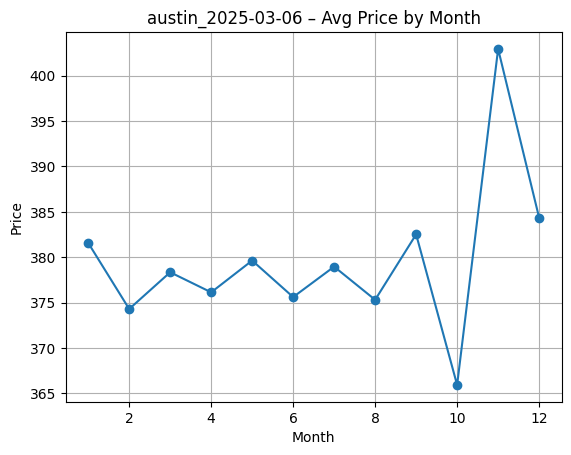

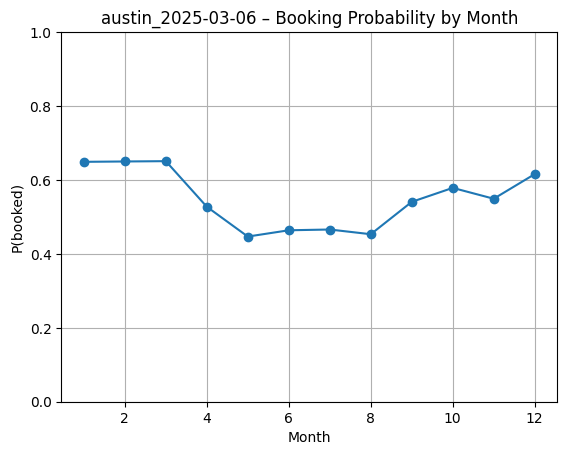

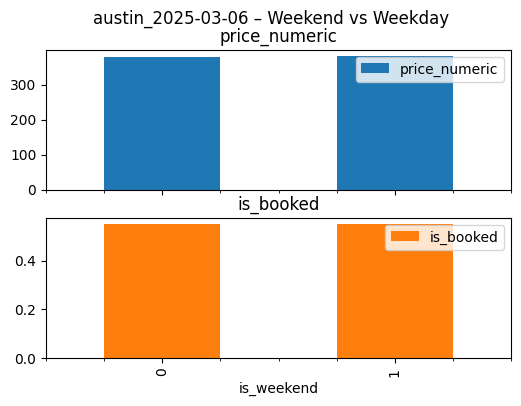

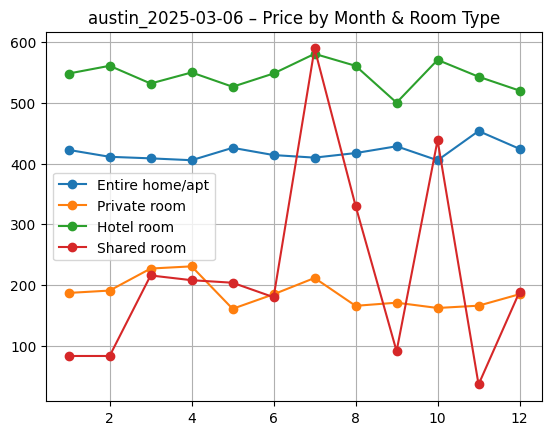

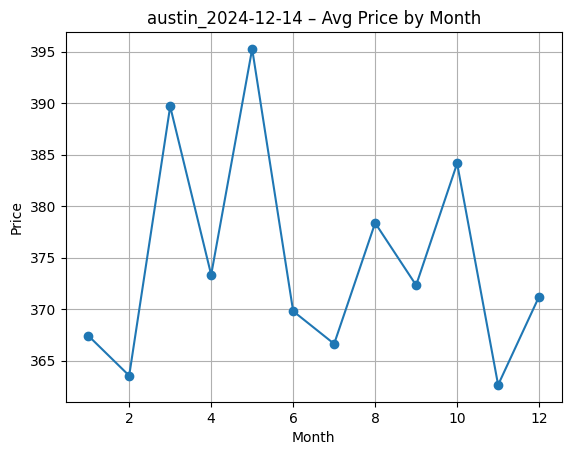

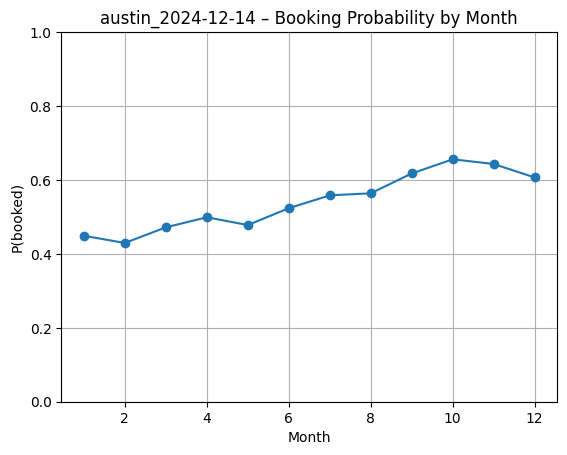

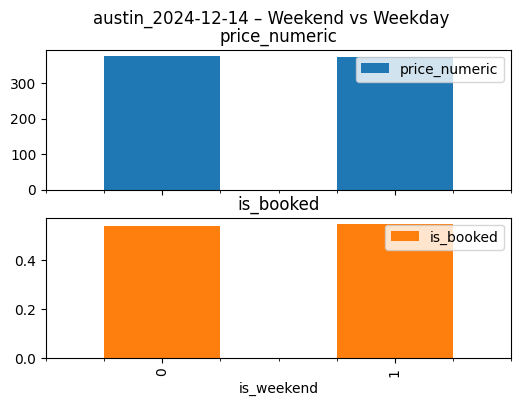

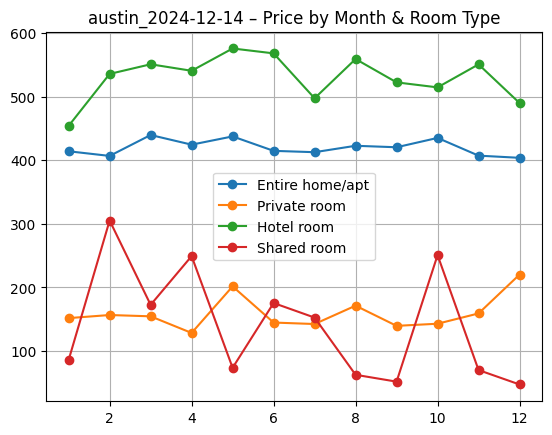

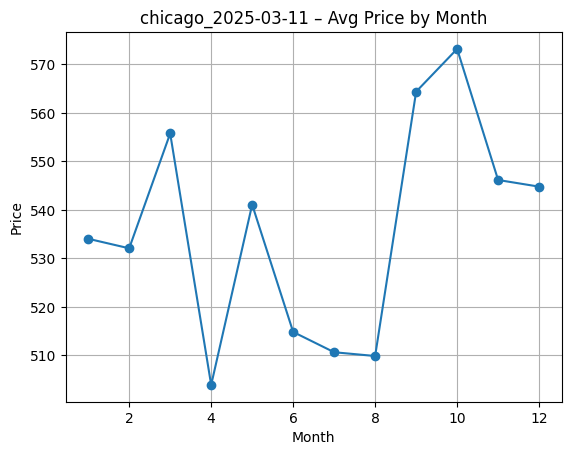

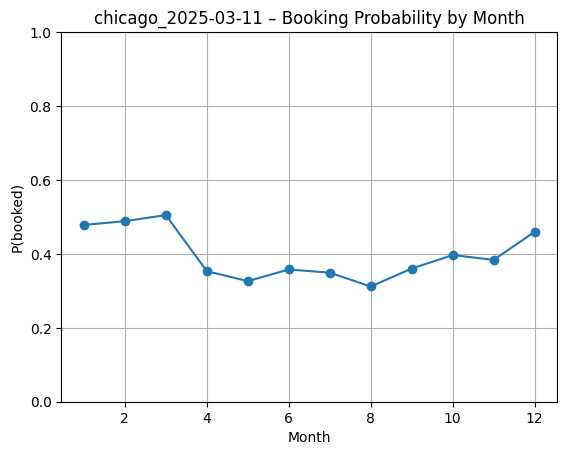

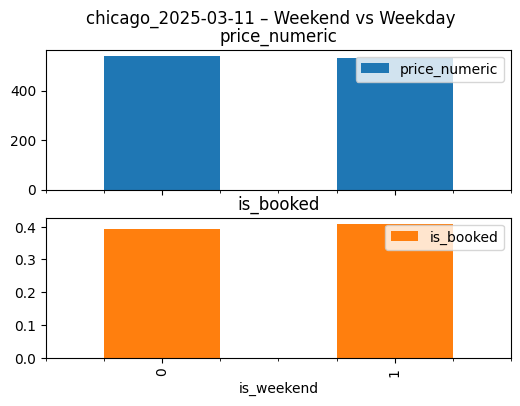

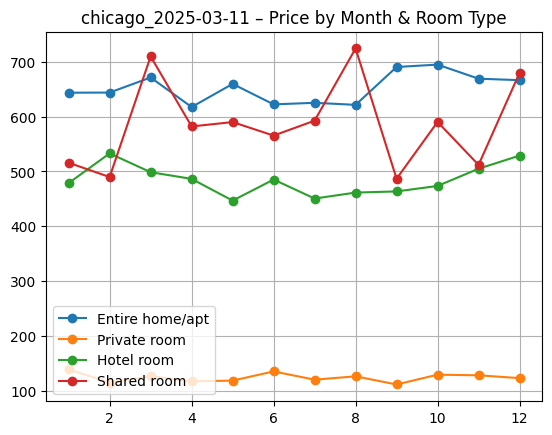

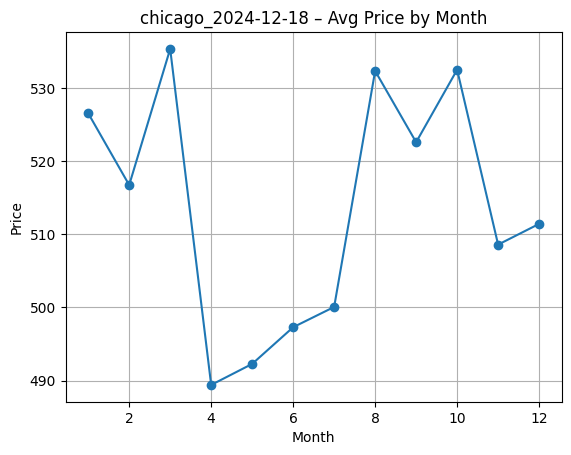

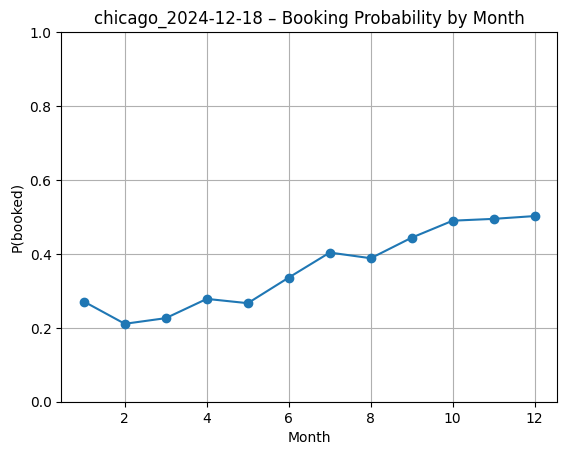

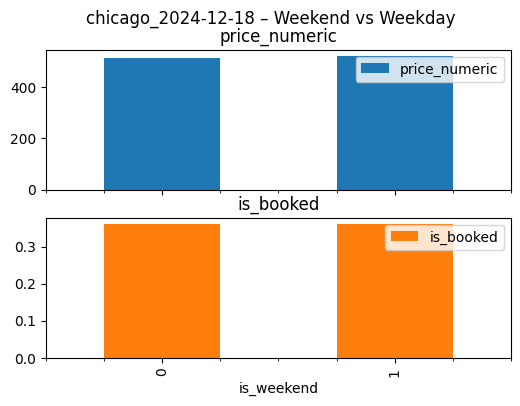

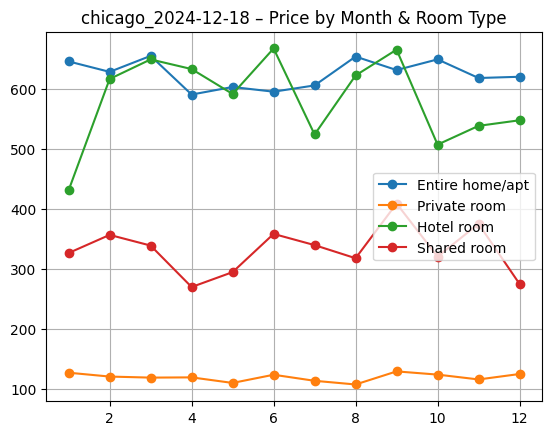

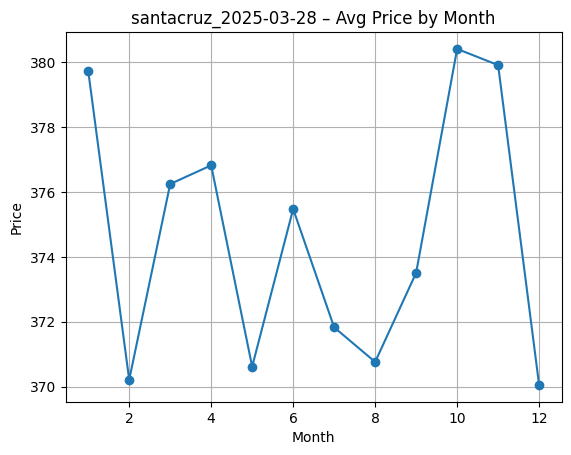

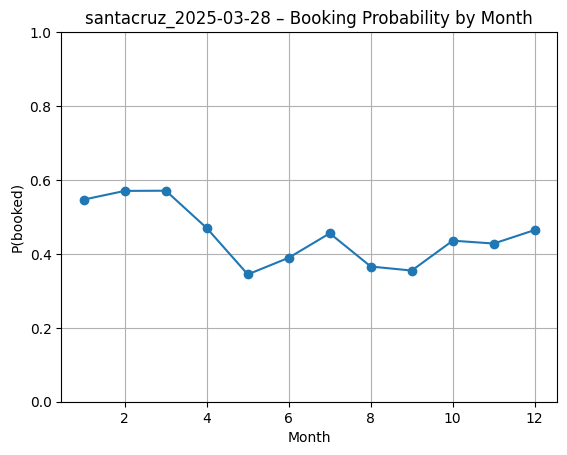

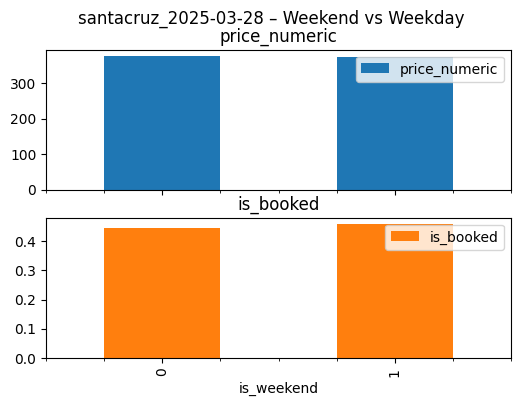

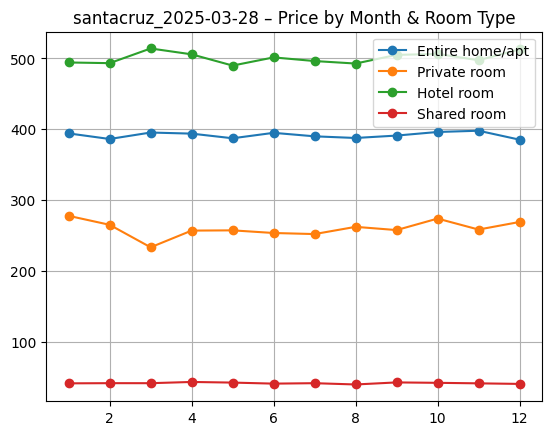

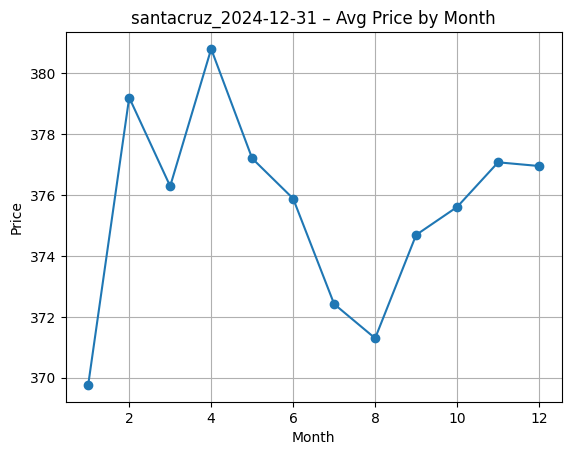

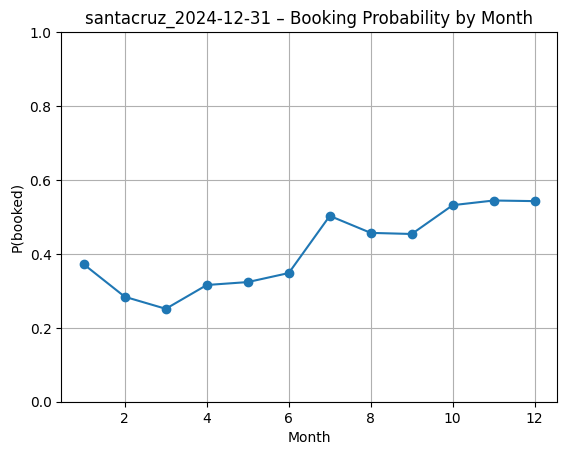

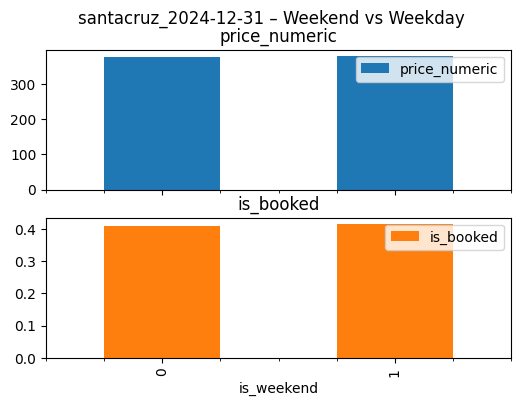

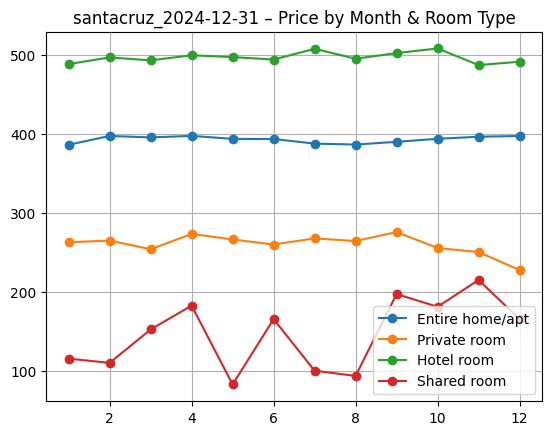

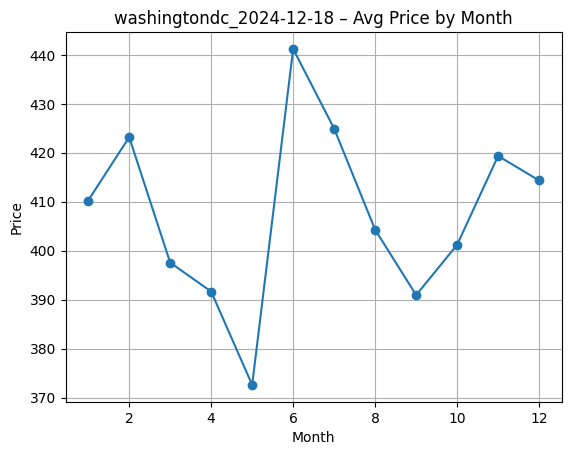

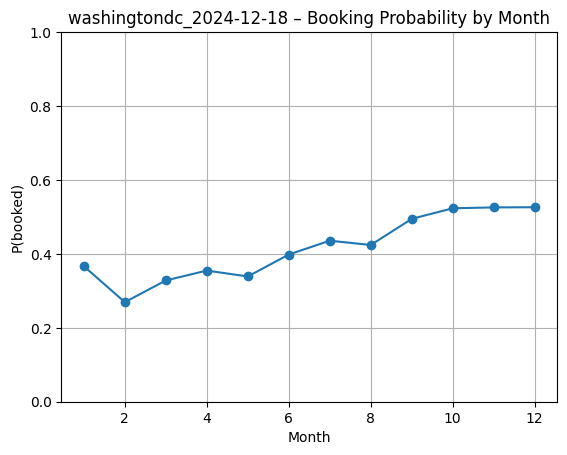

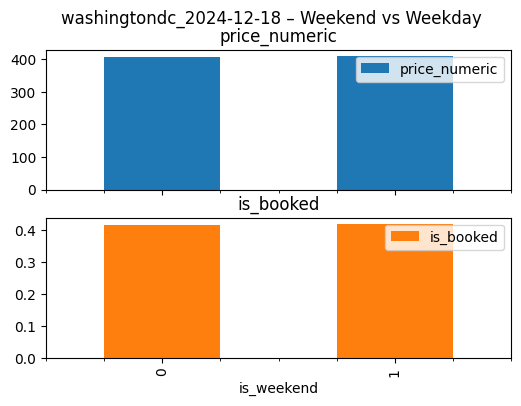

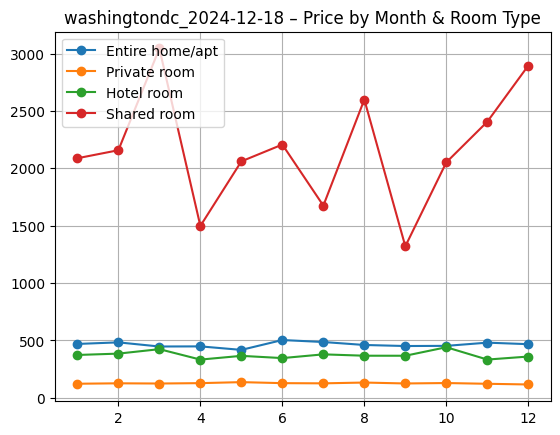

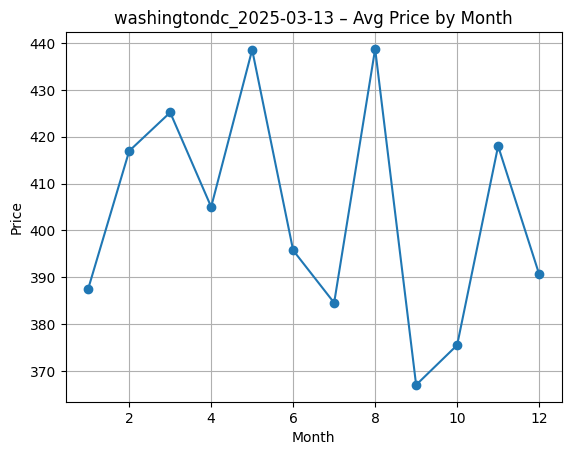

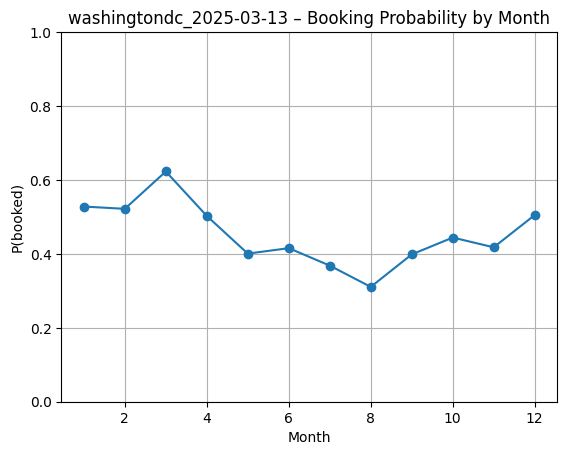

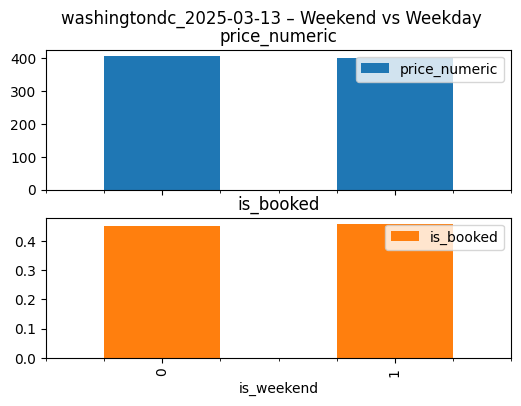

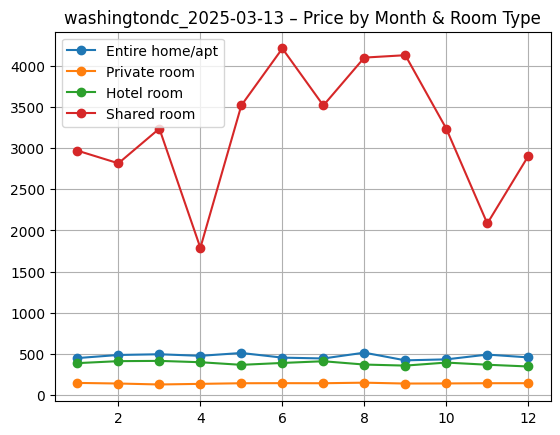

In [77]:
for key, df in panel_data.items():
    seasonality_plot(df, key)


In [78]:
def temporal_split(df):
    m = df["month"]

    split = np.select(
        [m.between(1, 9), m.isin([10, 11]), m.isin([12, 1, 2])],
        ["train", "valid", "test"],
        default="other"
    )

    return df[split == "train"], df[split == "valid"], df[split == "test"]

BASE_FEATURES = [
    "accommodates", "bedrooms", "beds",
    "review_scores_rating", "number_of_reviews",
    "month", "day_of_week", "is_weekend", "week_of_year", "day_of_year",
    "room_type"
]
TARGET_REG = "price_numeric"
TARGET_CLF = "is_booked"
def existing_features(df):
    return [c for c in BASE_FEATURES if c in df.columns]
train, valid, test = temporal_split(df)
features = existing_features(df)
print(train.shape, valid.shape, test.shape)


(74875, 90) (16571, 90) (8554, 90)


In [79]:
def plot_top_importances(model, names, title, top=15):
    imp = getattr(model, "feature_importances_", None)
    if imp is None:
        return
    idx = np.argsort(imp)[-top:]
    plt.figure(figsize=(10, 4))
    plt.barh(range(len(idx)), imp[idx])
    plt.yticks(range(len(idx)), np.array(names, dtype=object)[idx])
    plt.title(title)
    plt.tight_layout()
    plt.show()


def run_xgb_for_dataset(df, name, base_features, split_fn, target_reg="price_numeric", target_clf="is_booked", top=15):
    df = df.dropna(subset=["month", target_clf]).copy()
    train, valid, test = split_fn(df)

    print(f"\n{name} | splits:", train.shape, valid.shape, test.shape)
    if train.empty or valid.empty or test.empty:
        return {"dataset": name, "note": "empty split"}

    feats = [c for c in base_features if c in df.columns]
    cat = [c for c in feats if df[c].dtype == "object" or str(df[c].dtype).startswith("string")]
    num = [c for c in feats if c not in cat]

    pre = ColumnTransformer([
        ("num", SimpleImputer(strategy="median"), num),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore"))
        ]), cat)
    ])
    Xtr = pre.fit_transform(train[feats])
    Xva = pre.transform(valid[feats])
    Xte = pre.transform(test[feats])

    names = num.copy()
    if cat:
        oh = pre.named_transformers_["cat"].named_steps["oh"]
        names += list(oh.get_feature_names_out(cat))

    metrics = {"dataset": name, "train_rows": len(train), "valid_rows": len(valid), "test_rows": len(test)}
    tr_r = train.dropna(subset=[target_reg])
    va_r = valid.dropna(subset=[target_reg])
    te_r = test.dropna(subset=[target_reg])

    if not (tr_r.empty or va_r.empty or te_r.empty):
        Xtr_r = pre.fit_transform(tr_r[feats])
        Xva_r = pre.transform(va_r[feats])
        Xte_r = pre.transform(te_r[feats])

        reg = xgb.XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.05,
                               subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
        reg.fit(Xtr_r, tr_r[target_reg], eval_set=[(Xva_r, va_r[target_reg])], verbose=False)

        pred = reg.predict(Xte_r)
        metrics["xgb_price_rmse"] = mean_squared_error(te_r[target_reg], pred) ** 0.5
        metrics["xgb_price_mae"]  = mean_absolute_error(te_r[target_reg], pred)

        plot_top_importances(reg, names, f"{name} – XGB Price Importance", top=top)
    else:
        metrics["xgb_price_rmse"] = None
        metrics["xgb_price_mae"] = None
        metrics["note_price"] = "skipped (missing price in one split)"
    clf = xgb.XGBClassifier(n_estimators=500, max_depth=6, learning_rate=0.05,
                            subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1,
                            eval_metric="logloss")
    clf.fit(Xtr, train[target_clf], eval_set=[(Xva, valid[target_clf])], verbose=False)

    proba = clf.predict_proba(Xte)[:, 1]
    metrics["xgb_booked_auc"] = roc_auc_score(test[target_clf], proba)
    metrics["xgb_booked_acc"] = accuracy_score(test[target_clf], proba >= 0.5)

    plot_top_importances(clf, names, f"{name} – XGB Booking Importance", top=top)

    return metrics



austin_2025-03-06 | splits: (74915, 90) (16605, 90) (8480, 90)


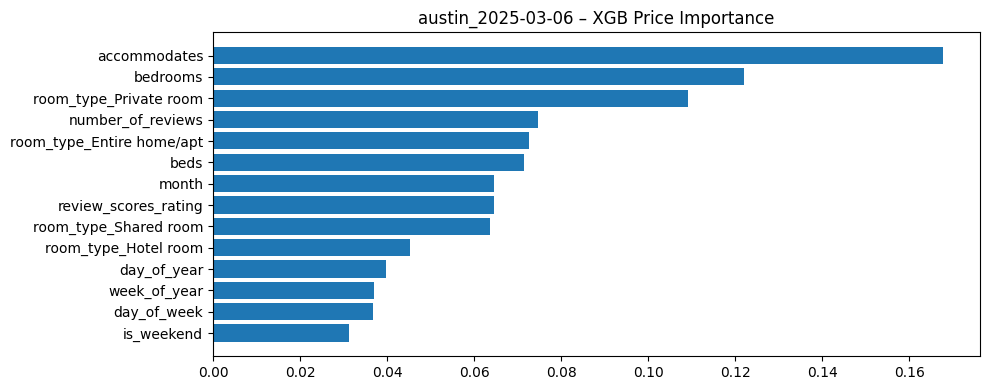

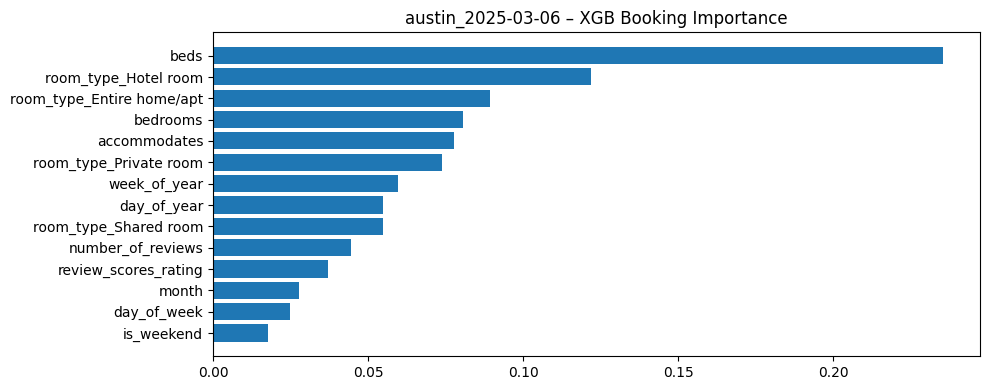


austin_2024-12-14 | splits: (74587, 86) (16741, 86) (8672, 86)


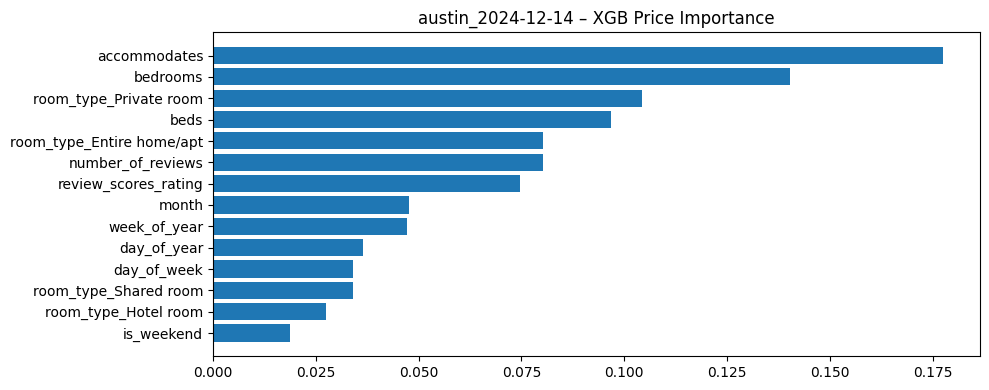

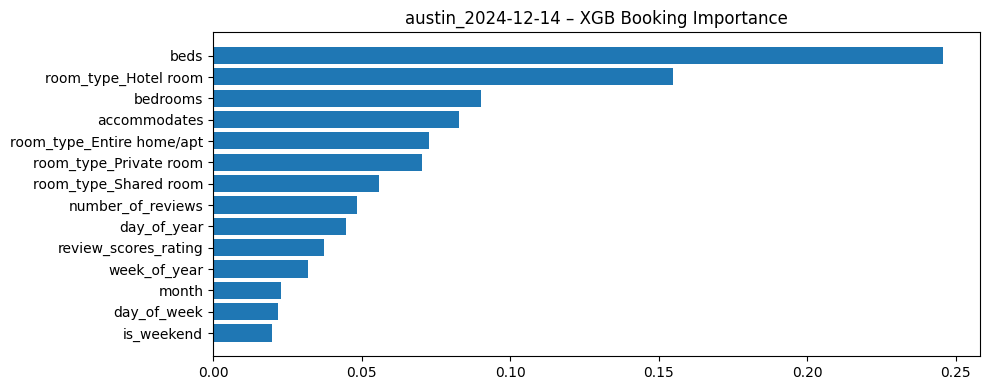


chicago_2025-03-11 | splits: (74815, 90) (16646, 90) (8539, 90)


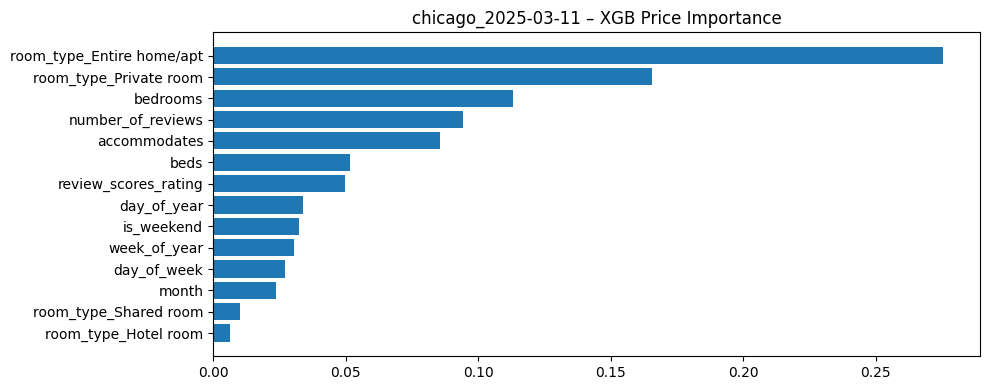

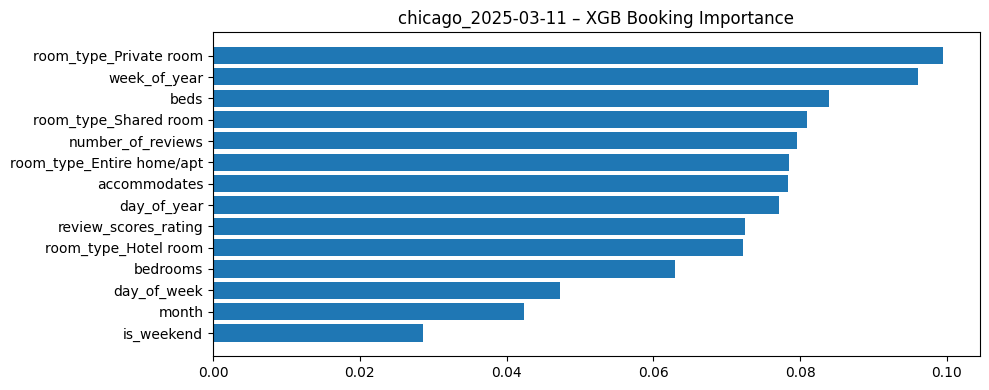


chicago_2024-12-18 | splits: (74799, 86) (16669, 86) (8532, 86)


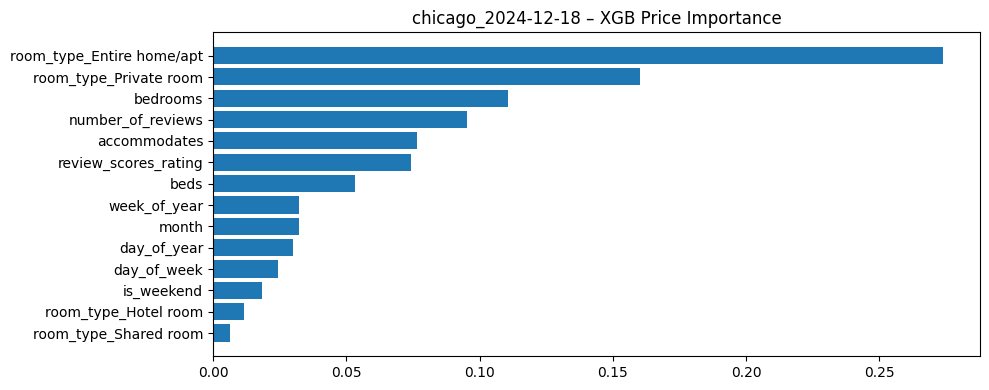

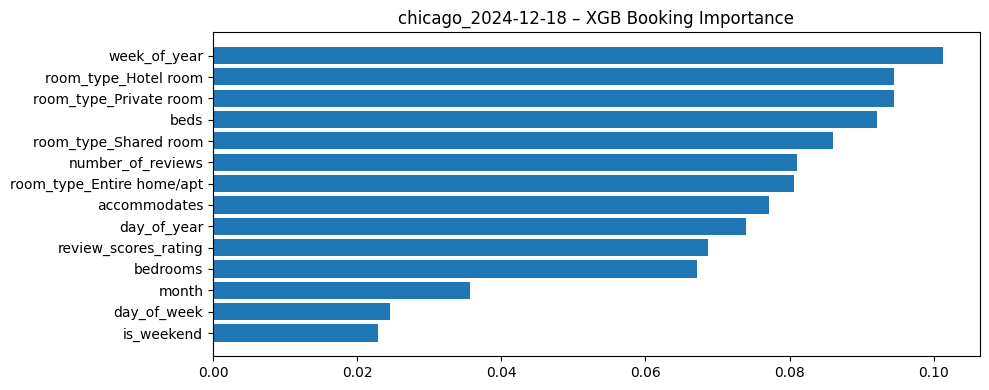


santacruz_2025-03-28 | splits: (74713, 90) (16685, 90) (8602, 90)


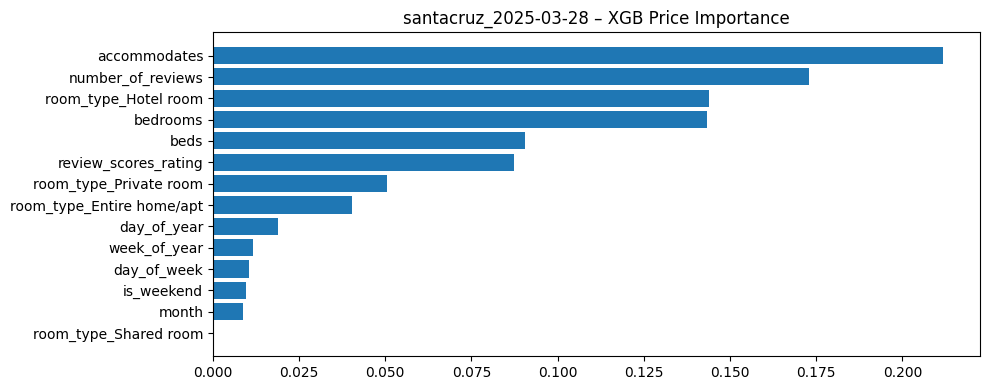

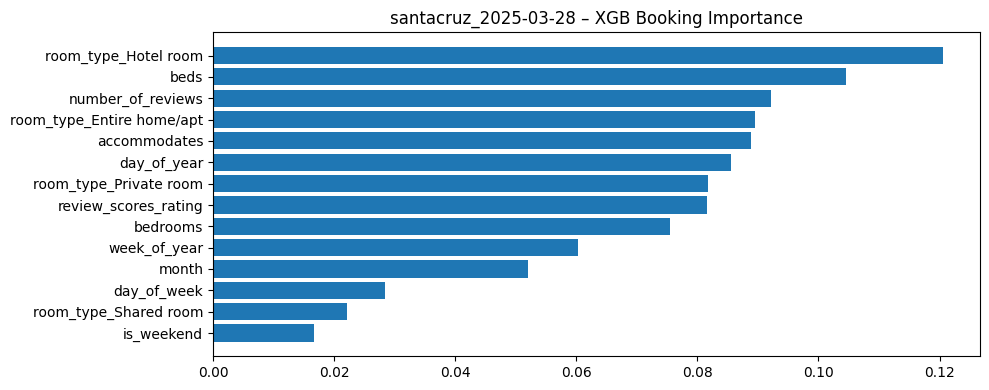


santacruz_2024-12-31 | splits: (74990, 86) (16562, 86) (8448, 86)


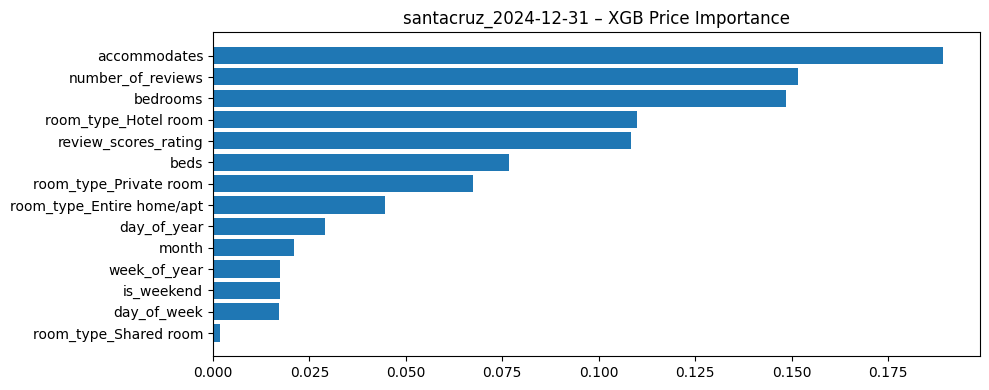

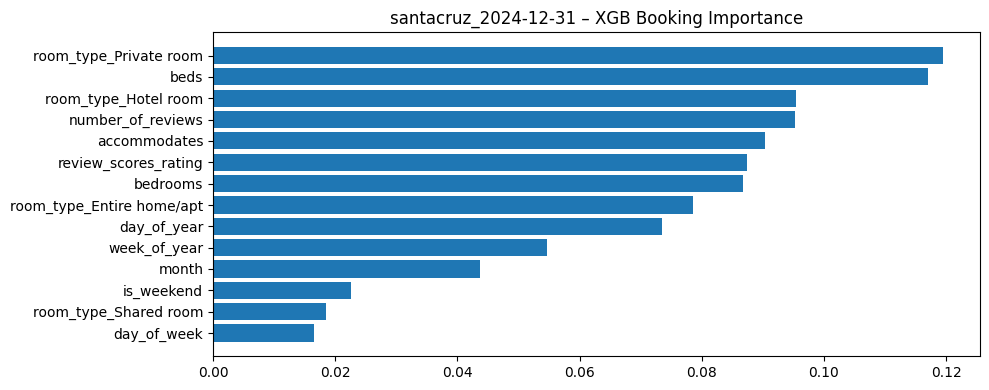


washingtondc_2024-12-18 | splits: (74782, 86) (16723, 86) (8495, 86)


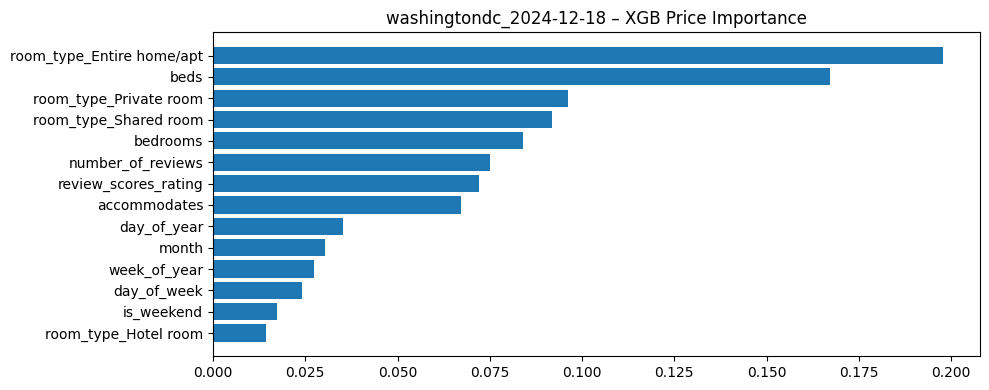

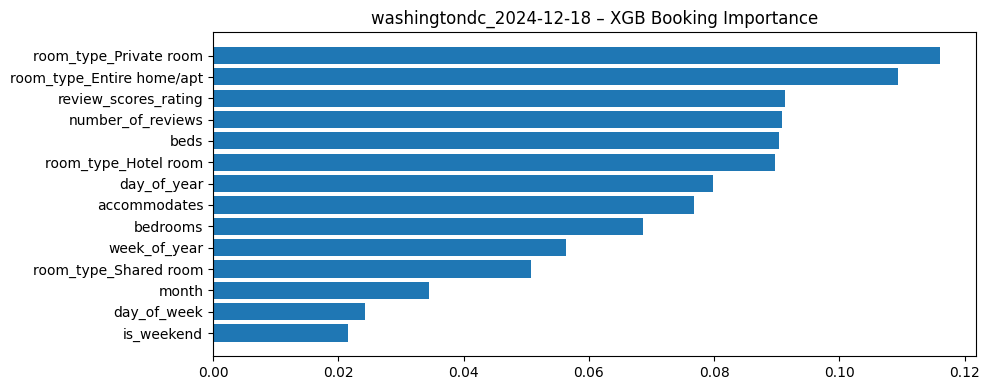


washingtondc_2025-03-13 | splits: (74875, 90) (16571, 90) (8554, 90)


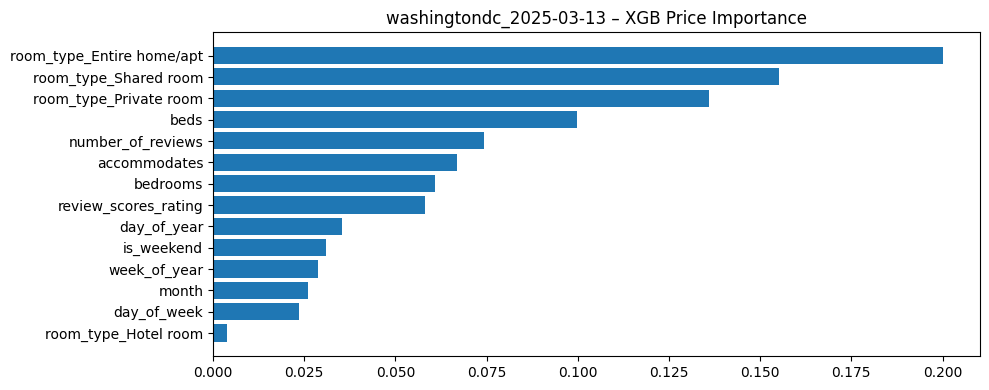

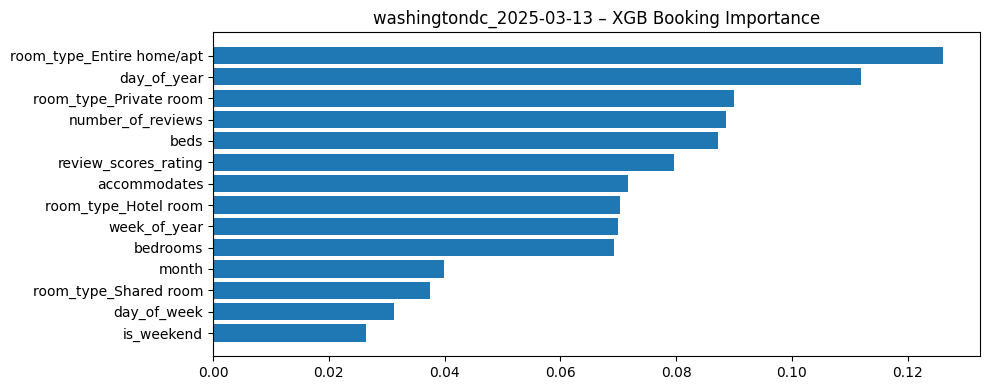

,dataset,train_rows,valid_rows,test_rows,xgb_price_rmse,xgb_price_mae,xgb_booked_auc,xgb_booked_acc
0,austin_2025-03-06,74915,16605,8480,893.366501,308.278318,0.767713,0.695165
1,austin_2024-12-14,74587,16741,8672,937.849993,271.287648,0.711122,0.656365
2,chicago_2025-03-11,74815,16646,8539,1955.633552,570.885640,0.701332,0.627240
3,chicago_2024-12-18,74799,16669,8532,1992.641177,560.085839,0.650093,0.607595
4,santacruz_2025-03-28,74713,16685,8602,198.199274,68.788870,0.829349,0.734713
5,santacruz_2024-12-31,74990,16562,8448,203.458790,83.491031,0.831496,0.754616
6,washingtondc_2024-12-18,74782,16723,8495,1721.006839,490.318107,0.681745,0.637081
7,washingtondc_2025-03-13,74875,16571,8554,1653.624819,374.456833,0.757216,0.694295


In [80]:
results = []
for key, df in panel_data.items():
    results.append(run_xgb_for_dataset(df, key, BASE_FEATURES, temporal_split, TARGET_REG, TARGET_CLF, top=15))

results_df = pd.DataFrame(results)
results_df


# We use 2 separate models:
Regression model predicts numeric price (price_numeric)
Classification model predicts probability of booking (is_booked)
Both share a similar MLP structure (dense layers with ReLU)
Regression: final layer has 1 output and NO sigmoid
Classification: final layer uses sigmoid so output becomes probability in [0, 1]

In [81]:
def build_nn_reg(d):
    m = tf.keras.Sequential([
        tf.keras.layers.Dense(256, "relu", input_shape=(d,)),
        tf.keras.layers.Dense(128, "relu"),
        tf.keras.layers.Dense(64, "relu"),
        tf.keras.layers.Dense(1)
    ])
    m.compile("adam", "mse", ["mae"])
    return m


def build_nn_clf(d):
    m = tf.keras.Sequential([
        tf.keras.layers.Dense(256, "relu", input_shape=(d,)),
        tf.keras.layers.Dense(128, "relu"),
        tf.keras.layers.Dense(64, "relu"),
        tf.keras.layers.Dense(1, "sigmoid")
    ])
    m.compile("adam", "binary_crossentropy", ["accuracy", tf.keras.metrics.AUC()])
    return m


# We pick one dataset for NN training (Austin snapshot).
The assignment wants a temporal split:
Train: Jan–Sep
Validation: Oct–Nov
Test: Dec–Feb

- Neural nets can’t take raw strings (like room_type).
So we:
- impute missing numeric values with median
- impute missing categories with most frequent
- one-hot encode categorical features
This creates a fully numeric feature matrix suitable for training.


In [89]:
def build_nn_reg(d):
    m = Sequential([Input(shape=(d,)),
                    Dense(256, "relu"), Dense(128, "relu"), Dense(64, "relu"),
                    Dense(1)])
    m.compile(optimizer=Adam(1e-3), loss="mse", metrics=["mae"])
    return m

def build_nn_clf(d):
    m = Sequential([Input(shape=(d,)),
                    Dense(256, "relu"), Dense(128, "relu"), Dense(64, "relu"),
                    Dense(1, "sigmoid")])
    m.compile(optimizer=Adam(1e-3), loss="binary_crossentropy",
              metrics=["accuracy", AUC(name="auc")])
    return m
def as_float32(X):
    if hasattr(X, "toarray"):
        X = X.toarray()
    return np.asarray(X, dtype=np.float32)
key = "austin_2025-03-06"
df = panel_data[key].copy()

train, valid, test = temporal_split(df)
print("splits:", train.shape, valid.shape, test.shape)

features = get_existing(df, BASE_FEATURES)
TARGET_REG = "price_numeric"
TARGET_CLF = "is_booked"

cat_cols = df[features].select_dtypes(include=["object", "string"]).columns.tolist()
num_cols = [c for c in features if c not in cat_cols]
pre = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        # key: force encoder output to float32
        ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=True, dtype=np.float32))
    ]), cat_cols),
], remainder="drop")

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
tr_r = train.dropna(subset=[TARGET_REG])
va_r = valid.dropna(subset=[TARGET_REG])
te_r = test.dropna(subset=[TARGET_REG])

Xtr = as_float32(pre.fit_transform(tr_r[features]))
Xva = as_float32(pre.transform(va_r[features]))
Xte = as_float32(pre.transform(te_r[features]))

ytr = tr_r[TARGET_REG].to_numpy(dtype=np.float32)
yva = va_r[TARGET_REG].to_numpy(dtype=np.float32)
yte = te_r[TARGET_REG].to_numpy(dtype=np.float32)

log_price = f"logs/nn_price/{key}_{stamp}"
cb_price = keras.callbacks.TensorBoard(log_dir=log_price)

nn_reg = build_nn_reg(Xtr.shape[1])
nn_reg.fit(Xtr, ytr, validation_data=(Xva, yva),
           epochs=10, batch_size=1024, callbacks=[cb_price], verbose=1)

pred = nn_reg.predict(Xte).ravel()
print(f"[NN Price] RMSE={(mean_squared_error(yte, pred)**0.5):.3f} MAE={mean_absolute_error(yte, pred):.3f}")
Xtr2 = as_float32(pre.fit_transform(train[features]))
Xva2 = as_float32(pre.transform(valid[features]))
Xte2 = as_float32(pre.transform(test[features]))

ytr2 = train[TARGET_CLF].to_numpy(dtype=np.float32)
yva2 = valid[TARGET_CLF].to_numpy(dtype=np.float32)
yte2 = test[TARGET_CLF].to_numpy(dtype=np.float32)

log_book = f"logs/nn_booked/{key}_{stamp}"
cb_book = keras.callbacks.TensorBoard(log_dir=log_book)

nn_clf = build_nn_clf(Xtr2.shape[1])
nn_clf.fit(Xtr2, ytr2, validation_data=(Xva2, yva2),
           epochs=10, batch_size=1024, callbacks=[cb_book], verbose=1)

proba = nn_clf.predict(Xte2).ravel()
print(f"[NN Booked] AUC={roc_auc_score(yte2, proba):.3f} ACC={accuracy_score(yte2, proba >= 0.5):.3f}")


splits: (74915, 90) (16605, 90) (8480, 90)
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1280517.5000 - mae: 342.7076 - val_loss: 1079358.0000 - val_mae: 413.9450
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1254484.5000 - mae: 320.1064 - val_loss: 1034865.1875 - val_mae: 303.7711
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1059542.6250 - mae: 299.9074 - val_loss: 1034825.8750 - val_mae: 345.8368
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1024233.6875 - mae: 296.4561 - val_loss: 1044212.1250 - val_mae: 385.5401
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1174923.5000 - mae: 303.9856 - val_loss: 1043383.9375 - val_mae: 384.0792
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1117161.2500 - mae: 324.9670 - val_loss: 1033499.8125 - val_mae: 298.4634
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1154462.8750 - mae: 301.0131 - val_loss: 1035983.7500 - val_mae: 353.0456
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━

### TensorBoard Interpretation (NN)

For the price regression model, the training and validation loss decrease steadily and remain relatively close, suggesting stable learning and limited overfitting. The validation MAE also decreases over epochs, showing that the model improves its price predictions on unseen data.

For the booking classification model, the AUC increases across epochs and the validation AUC tracks the training AUC closely, indicating the model generalizes well. Overall, the booking task appears easier than exact price prediction, which makes sense because booking is a coarser outcome compared to predicting the exact nightly rate.


### TensorBoard: NN Price Model
![NN Price Scalars](?images/NN_price.png)

### TensorBoard: NN Booking Model
![NN Booking Scalars](/images/NN_booked.png)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs
